# Lab 05: Merging and Joining Data

This lab is presented with some revisions from [Dennis Sun at Cal Poly](https://web.calpoly.edu/~dsun09/index.html) and his [Data301 Course](http://users.csc.calpoly.edu/~dsun09/data301/lectures.html)

### When you have filled out all the questions, submit via [Tulane Canvas](https://tulane.instructure.com/)

In [ ]:
# clone the course repository, change to right directory, and import libraries.
%cd /content
!git clone https://github.com/nmattei/cmps3160.git
%cd /content/cmps3160/_labs/Lab05
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/content
fatal: destination path 'cmps3160' already exists and is not an empty directory.
/content/cmps3160/_labs/Lab05


In many situtions, the information you need is spread across multiple data sets, so you will need to combine multiple data sets into one. In this lab, we explore how to combine information from multiple (tabular) data sets.

As a working example, we will use the baby names data collected by the Social Security Administration. Each data set in this collection contains the names of all babies born in the United States in a particular year. This data is [publicly available](https://www.ssa.gov/OACT/babynames/limits.html), and a copy has been made available at `../data/names.zip`.

We will first unzip the files in `../data/names.zip` into a new directory in the current folder called `data/`.

In [ ]:
!mkdir -p ../data/names
!unzip ../data/names.zip -d ../data/names

Archive:  ../data/names.zip
replace ../data/names/yob1880.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

As you can see this data is broken up into a lot of individual files, but if we want to use any of our `groupby` and other analysis techniques we need to make it into one file!

## Concatenation

Sometimes, the _rows_ of data are spread across multiple files, and we want to combine the rows into a single data set. The process of combining rows from different data sets is known as **concatenation**. Visually, to concatenate two or more `DataFrame`s means to stack them on top of one another.

<img src="https://github.com/nmattei/cmps3160/blob/master/_labs/images/concatenate.png?raw=1" width="400">

For example, suppose we want to understand how the popularity of different names evolved between 1995 and 2015. The 1995 names and the 2015 names are stored in two different files: `yob1995.txt` and `yob2015.txt`, respectively. To carry out this analysis, we will need to combine these two data sets into one.

In [ ]:
# Show a ludicrus number of rows and columns
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
pd.options.display.width = 1000

names1995 = pd.read_csv("../data/names/yob1995.txt",
                        header=None,
                        names=["Name", "Sex", "Count"])
names1995.head()

,Name,Sex,Count
0,Jessica,F,27938
1,Ashley,F,26602
2,Emily,F,24380
3,Samantha,F,21644
4,Sarah,F,21383


In [ ]:
names2015 = pd.read_csv("../data/names/yob2015.txt",
                        header=None,
                        names=["Name", "Sex", "Count"])
names2015.head()

,Name,Sex,Count
0,Emma,F,20455
1,Olivia,F,19691
2,Sophia,F,17417
3,Ava,F,16378
4,Isabella,F,15617


To concatenate the two, we use the `pd.concat()` function, which accepts a _list_ of `pandas` objects (`DataFrames` or `Series`) and concatenates them.

In [ ]:
pd.concat([names1995, names2015])

,Name,Sex,Count
0,Jessica,F,27938
1,Ashley,F,26602
2,Emily,F,24380
3,Samantha,F,21644
4,Sarah,F,21383
...,...,...,...
33116,Zykell,M,5
33117,Zyking,M,5
33118,Zykir,M,5
33119,Zyrus,M,5


There are two problems with the combined data set above. First, there is no longer any way to distinguish the 1995 data from the 2015 data. To fix this, we can add a "Year" column to each `DataFrame` before we concatenate. Second, the indexes from the individual `DataFrame`s have been preserved. (To see this, observe that the last index in the `DataFrame` is 32,951, which corresponds to the number of rows in `names2015`, but there are actually 59,032 rows in the `DataFrame`.) That means that there are two rows with an index of 0, two rows with an index of 1, and so on. To force `pandas` to create a completely new index for this `DataFrame`, ignoring the indices from the individual `DataFrame`s, we specify `ignore_index=True`.

In [ ]:
names1995["Year"] = 1995
names2015["Year"] = 2015
names = pd.concat([names1995, names2015], ignore_index=True)
names

,Name,Sex,Count,Year
0,Jessica,F,27938,1995
1,Ashley,F,26602,1995
2,Emily,F,24380,1995
3,Samantha,F,21644,1995
4,Sarah,F,21383,1995
...,...,...,...,...
59196,Zykell,M,5,2015
59197,Zyking,M,5,2015
59198,Zykir,M,5,2015
59199,Zyrus,M,5,2015


Now this is a `DataFrame` that we can use!

Notice that the data is currently in tabular form, with one row per combination of name, sex, and year. It makes sense to set these to be the index of our `DataFrame`.

In [ ]:
names.set_index(["Name", "Sex", "Year"], inplace=True)
names.head()

,,,Count
Name,Sex,Year,
Jessica,F,1995,27938
Ashley,F,1995,26602
Emily,F,1995,24380
Samantha,F,1995,21644
Sarah,F,1995,21383


We may want to show the counts for the two years side by side. In other words, we want a data cube with (name, sex) along one axis and year along the other. To do this, we can `.unstack()` the year from the index.  Note this is similar to a reverse Melt operation that we talked about in class -- a more tidy data way to do this may be to setup year as a multi index.

In [ ]:
names.unstack("Year").head()

Count      
Year           1995  2015
Name      Sex            
Aaban     M     NaN  15.0
Aabha     F     NaN   7.0
Aabriella F     NaN   5.0
Aada      F     NaN   5.0
Aadam     M     6.0  22.0

The `NaN`s simply indicate that there were no children (more precisely, if you read [the documentation](https://www.ssa.gov/OACT/babynames/limits.html), fewer than five children) born in the United States in that year. In this case, it makes sense to fill these `NaN` values with 0.

In [ ]:
names.unstack().fillna(0).head()

Count      
Year           1995  2015
Name      Sex            
Aaban     M     0.0  15.0
Aabha     F     0.0   7.0
Aabriella F     0.0   5.0
Aada      F     0.0   5.0
Aadam     M     6.0  22.0

# Merging (a.k.a. Joining)

More commonly, the data sets that we want to combine actually contain different information about the same observations. In other words, instead of stacking the `DataFrame`s on top of each other, as in concatenation, we want to stack them next to each other. The process of combining columns or variables from different data sets is known as **merging** or **joining**.

<img src="https://github.com/nmattei/cmps3160/blob/master/_labs/images/merge.png?raw=1" width="400">

The observations in the two data sets may not be in the same order, so merging is not as simple as stacking the `DataFrame`s side by side. For example, the process might look as follows:

![](https://github.com/nmattei/cmps3160/blob/master/_labs/images/one-to-one.png?raw=1)

In _pandas_, merging is accomplished using the `.merge()` function. We have to specify the variable(s) that we want to match across the two data sets. For example, to merge the 1995 names with the 2015 names, we have to join on name and sex.

In [ ]:
names1995.merge(names2015, on=["Name", "Sex"]).head()

,Name,Sex,Count_x,Year_x,Count_y,Year_y
0,Jessica,F,27938,1995,1587,2015
1,Ashley,F,26602,1995,3424,2015
2,Emily,F,24380,1995,11786,2015
3,Samantha,F,21644,1995,5340,2015
4,Sarah,F,21383,1995,4521,2015


The variables `Name` and `Sex` that we joined on each appear once in the resulting `DataFrame`. The variable `Count`, which we did not join on, appears twice---since there are columns called `Count` in both `DataFrame`s. Notice that `pandas` automatically appended the suffix `_x` to the name of the variable from the left data set and `_y` to the name from the right. We can customize the suffixes by specifying the `suffixes=` argument.

In [ ]:
names1995.merge(names2015, on=["Name", "Sex"], suffixes=("1995", "2015")).head()

,Name,Sex,Count1995,Year1995,Count2015,Year2015
0,Jessica,F,27938,1995,1587,2015
1,Ashley,F,26602,1995,3424,2015
2,Emily,F,24380,1995,11786,2015
3,Samantha,F,21644,1995,5340,2015
4,Sarah,F,21383,1995,4521,2015


In the code above, we assumed that the columns that we joined on had the same names in the two data sets. What if they had different names? For example, suppose the columns had been lowercase in one and uppercase in the other. We can specify which variables to use from the left and right data sets using the `left_on=` and `right_on=` arguments.

In [ ]:
# Create new DataFrames where the column names are different
names1995_lower = names1995.copy()
names2015_upper = names2015.copy()
names1995_lower.columns = names1995.columns.str.lower()
names2015_upper.columns = names2015.columns.str.upper()

# This is how you merge them.
names1995_lower.merge(
    names2015_upper,
    left_on=("name", "sex"),
    right_on=("NAME", "SEX")
).head()

,name,sex,count,year,NAME,SEX,COUNT,YEAR
0,Jessica,F,27938,1995,Jessica,F,1587,2015
1,Ashley,F,26602,1995,Ashley,F,3424,2015
2,Emily,F,24380,1995,Emily,F,11786,2015
3,Samantha,F,21644,1995,Samantha,F,5340,2015
4,Sarah,F,21383,1995,Sarah,F,4521,2015


Note that here we've managed to get some redundant columns so we would need to drop these to keep our data tidy!

What if the "variables" that we want to join on are in the index? We can always call `.reset_index()` to make them columns, but we can also specify the arguments `left_index=True` or `right_index=True` to force `pandas` to use the index instead of columns.  Note that if we were to use the Pandas `join` command the default action would be to join on the indicies.

In [ ]:
names1995_idx = names1995.set_index(["Name", "Sex"])
names1995_idx.head()

,,Count,Year
Name,Sex,,
Jessica,F,27938,1995
Ashley,F,26602,1995
Emily,F,24380,1995
Samantha,F,21644,1995
Sarah,F,21383,1995


In [ ]:
names1995_idx.merge(names2015, left_index=True, right_on=("Name", "Sex")).head()

,Count_x,Year_x,Name,Sex,Count_y,Year_y
205,27938,1995,Jessica,F,1587,2015
84,26602,1995,Ashley,F,3424,2015
7,24380,1995,Emily,F,11786,2015
39,21644,1995,Samantha,F,5340,2015
56,21383,1995,Sarah,F,4521,2015


Note that this worked because the left `DataFrame` had an index with two levels, which were joined to two columns from the right `DataFrame`.

# One-to-One and Many-to-One Relationships

In the example above, there was at most one (name, sex) combination in the 2015 data set for each (name, sex) combination in the 1995 data set. These two data sets are thus said to have a **one-to-one relationship**. Another example of a one-to-one data set is the Beatles example from above. Each Beatle appears in each data set exactly once, so the name is uniquely identifying.

![](https://github.com/nmattei/cmps3160/blob/master/_labs/images/one-to-one.png?raw=1)

However, two data sets need not have a one-to-one relationship. For example, a data set that specifies the instrument(s) that each Beatle played would potentially feature each Beatle multiple times (if they played multiple instruments). If we joined this data set to the "Beatles career" data set, then each row in the "Beatles career" data set would be mapped to several rows in the "instruments" data set. These two data sets are said to have a **many-to-one relationship**.

![](https://github.com/nmattei/cmps3160/blob/master/_labs/images/many-to-one.png?raw=1)

# Many-to-Many Relationships: A Cautionary Tale

In the baby names data, the name is not uniquely identifying. For example, there are both males and females with the name "Jessie".

In [ ]:
jessie1995 = names1995[names1995["Name"] == "Jessie"]
jessie2015 = names2015[names2015["Name"] == "Jessie"]

jessie1995

,Name,Sex,Count,Year
248,Jessie,F,1138,1995
16046,Jessie,M,903,1995


That is why we have to be sure to join on both name and sex. But what would go wrong if we joined these two `DataFrame`s on just "Name"? Let's try it out:

In [ ]:
jessie1995.merge(jessie2015, on=["Name"])

,Name,Sex_x,Count_x,Year_x,Sex_y,Count_y,Year_y
0,Jessie,F,1138,1995,F,469,2015
1,Jessie,F,1138,1995,M,233,2015
2,Jessie,M,903,1995,F,469,2015
3,Jessie,M,903,1995,M,233,2015


We see that Jessie ends up appearing four times.

- Female Jessies from 1995 are matched with female Jessies from 2015. (Good!)
- Male Jessies from 1995 are matched with male Jessies from 2015. (Good!)
- Female Jessies from 1995 are matched with male Jessies from 2015. (Huh?)
- Male Jessies from 1995 are matched with female Jessies from 2015. (Huh?)

The problem is that there were multiple Jessies in the 1995 data and multiple Jessies in the 2015 data. We say that these two data sets have a **many-to-many relationship**.

# Joining Data

In the previous section, we discussed how to _merge_ (or _join_) two data sets by matching on certain variables. But what happens when no match can be found for a row in one `DataFrame`?

First, let's determine how _pandas_ handles this situation by default. The name "Nevaeh", which is "Heaven" spelled backwards, is said to have taken off when Sonny Sandoval of the band P.O.D. gave his daughter the name in 2000. Let's look at how common this name was four years earlier and four years after.

In [ ]:
names1996 = pd.read_csv("../data/names/yob1996.txt",
                        header=None,
                        names=["Name", "Sex", "Count"])
names2004 = pd.read_csv("../data/names/yob2004.txt",
                        header=None,
                        names=["Name", "Sex", "Count"])

In [ ]:
names1996[names1996.Name == "Nevaeh"]

,Name,Sex,Count


In [ ]:
names2004[names2004.Name == "Nevaeh"]

,Name,Sex,Count
103,Nevaeh,F,3179
21764,Nevaeh,M,35


In 1996, there were no girls (or fewer than 5) named Nevaeh; just eight years later, there were over 3000 girls (and 27 boys) with the name. It seems like Sonny Sandoval had a huge effect.

What will happen to the name "Nevaeh" when we merge the two data sets?

In [ ]:
names = names1996.merge(names2004, on=["Name", "Sex"], suffixes=("1996", "2004"))
names[names.Name == "Nevaeh"]

,Name,Sex,Count1996,Count2004


By default, _pandas_ only includes combinations that are present in _both_ `DataFrame`s. If it cannot find a match for a row in one `DataFrame`, then the combination is simply dropped.

But in this context, the fact that a name does not appear in one data set is informative. It means that no babies were born in that year with that name. (Technically, it means that fewer than 5 babies were born with that name, as any name that was assigned fewer than 5 times is omitted for privacy reasons.) We might want to include names that appeared in only one of the two `DataFrame`s, rather than just the names that appeared in both.

There are four types of joins, distinguished by whether they include names from the left `DataFrame`, the right `DataFrame`, both, or neither:

1. **inner join** (default): only values that are present in _both_ `DataFrame`s are included in the result
2. **outer join**: any value that appears in _either_ `DataFrame` is included in the result
3. **left join**: any value that appears in the _left_ `DataFrame` is included in the result, whether or not it appears in the right `DataFrame`
4. **right join**: any value that appears in the _right_ `DataFrame` is included in the result, whether or not it appears in the left `DataFrame`.

In _pandas_, the join type is specified using the `how=` argument.

Now let's look at examples of each of these types of joins.

In [ ]:
# inner join
names_inner = names1996.merge(names2004, on=["Name", "Sex"], how="inner", suffixes=("1996", "2004"))
names_inner.head()

,Name,Sex,Count1996,Count2004
0,Emily,F,25151,25037
1,Jessica,F,24198,9470
2,Ashley,F,23677,14373
3,Sarah,F,21040,12737
4,Samantha,F,20548,13783


In [ ]:
# outer join
names_outer = names1996.merge(names2004, on=["Name", "Sex"], how="outer", suffixes=("1996", "2004"))
names_outer.head()

,Name,Sex,Count1996,Count2004
0,Emily,F,25151.0,25037.0
1,Jessica,F,24198.0,9470.0
2,Ashley,F,23677.0,14373.0
3,Sarah,F,21040.0,12737.0
4,Samantha,F,20548.0,13783.0


Names like "Zyrell" and "Zyron" appeared in the 2004 data but not the 1996 data. For this reason, their count in 1996 is `NaN`. In general, there will be `NaN`s in a `DataFrame` resulting from an outer join. Any time a name appears in one `DataFrame` but not the other, there will be `NaN`s in the columns from the `DataFrame` whose data is missing.

In [ ]:
names_outer.isnull().sum()

Name             0
Sex              0
Count1996    11988
Count2004     6363
dtype: int64

By contrast, there are no `NaN`s when we do an inner join. That is because we restrict to only the (name, sex) pairs that appeared in both `DataFrame`s, so we have counts for both 1996 and 2014.

In [ ]:
names_inner.isnull().sum()

Name         0
Sex          0
Count1996    0
Count2004    0
dtype: int64

Left and right joins preserve data from one `DataFrame` but not the other. For example, if we were trying to calculate the percentage change for each name from 1996 to 2004, we would want to include all of the names that appeared in the 1996 data. If the name did not appear in the 2004 data, then that is informative.

In [ ]:
# left join
names_left = names1996.merge(names2004, on=["Name", "Sex"], how="left", suffixes=("1996", "2004"))
names_left.head()

,Name,Sex,Count1996,Count2004
0,Emily,F,25151,25037.0
1,Jessica,F,24198,9470.0
2,Ashley,F,23677,14373.0
3,Sarah,F,21040,12737.0
4,Samantha,F,20548,13783.0


The result of a left join has `NaN`s in the column from the right `DataFrame`.

In [ ]:
names_left.isnull().sum()

Name            0
Sex             0
Count1996       0
Count2004    6363
dtype: int64

The result of a right join, on the other hand, has `NaN`s in the column from the left `DataFrame`.

In [ ]:
# right join
names_right = names1996.merge(names2004, on=["Name", "Sex"], how="right", suffixes=("1996", "2004"))
names_right.head()

,Name,Sex,Count1996,Count2004
0,Emily,F,25151.0,25037
1,Emma,F,6144.0,21607
2,Madison,F,13410.0,20622
3,Olivia,F,8123.0,16105
4,Hannah,F,18596.0,15605


In [ ]:
names_right.isnull().sum()

Name             0
Sex              0
Count1996    11988
Count2004        0
dtype: int64

One way to visualize the different types of joins is using Venn diagrams. The shaded circles specify which values are included in the output.

![](https://github.com/nmattei/cmps3160/blob/master/_labs/images/joins.jpeg?raw=1)

# Exercises

**Exercise 1.** Make a line plot showing the popularity of your name over the years.  Make sure you include all the years in the dataset!  You'll need to write some code to make sure you open **all** the year datafiles.

**Hint:** Maybe try out the [Python Glob Package](https://docs.python.org/3/library/glob.html).

(**BONUS Extra Credit (1 point)**: As an added challenge, try marking the year you were born with a graphic element.)


In [ ]:
import os
import glob
df_list = [] # empty list
for f in glob.glob('../data/names/*.txt'): # iterates through each file
  df = pd.read_csv(f, header = None, names = ['Name', 'Sex', 'Count']) #reads all the data into a dataframe
  f1 = f.split('/') # splits each file
  df['Year'] = (f1[-1][3:7]) # retrieves the year from the file name
  df_list.append(df) # appends the data to the empty list based on years
df_total = pd.concat(df_list)

In [ ]:
df_total

,Name,Sex,Count,Year
0,Mary,F,65838,1919
1,Helen,F,33706,1919
2,Dorothy,F,31734,1919
3,Margaret,F,26237,1919
4,Ruth,F,24565,1919
...,...,...,...,...
3259,Wince,M,5,1898
3260,Winford,M,5,1898
3261,Wing,M,5,1898
3262,Wyman,M,5,1898


<ipython-input-180-940a24e47dd8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sydney.sort_index(inplace = True) # sorts the index in place


<Axes: xlabel='Year'>

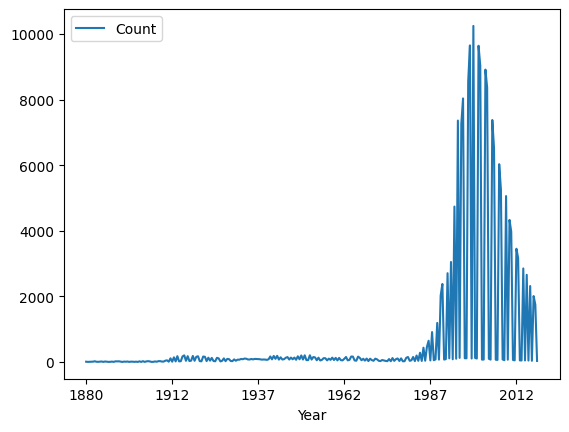

In [ ]:
df_sydney = df_total.loc[df_total['Name'] == 'Sydney'] # creates a data frame with all 'Sydney's
df_sydney.set_index('Year', inplace = True) # sets the index in place as year
df_sydney.sort_index(inplace = True) # sorts the index in place
df_sydney.plot.line() # creates the line graph of the popularity of my name over all years

The following questions deal with the [Movielens data 1M Dataset](https://grouplens.org/datasets/movielens/1m/) which is at `../data/movielens.zip`.

**Exercise 2.** First, we'll need to unzip the contents of this file to `../data/movielens`.


In [ ]:
!mkdir -p ../data/movielens
!unzip ../data/movielens.zip -d ../data/movielens

Archive:  ../data/movielens.zip
replace ../data/movielens/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: 


This dataset is a collection of movie ratings submitted by users. The information about the movies, ratings, and users are stored in three separate files, called `movies.dat`, `ratings.dat`, and `users.dat`. The column names are not included with the data files. Refer to the data documentation (`../data/movielens/README`) for the column names and how the columns correspond across the data sets.

**Exercise 3.** Next, you need to open these three datafiles, make sure the column headers are correct, and merge them into a single DataFrame to answer the questions.  Take note of the seperators in the data and maybe look at the documentation for [Pandas read_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) for some hints. If you're having encoding issues, try adding `encoding="ISO-8859-1"` to the `read_csv` call.

In [ ]:
movies = pd.read_csv("../data/movielens/movies.dat", encoding="ISO-8859-1", sep="::", engine="python", names=['MovieID', 'Title', 'Genres'])
ratings = pd.read_csv("../data/movielens/ratings.dat", encoding="ISO-8859-1", sep="::", engine="python", names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
users = pd.read_csv("../data/movielens/users.dat", encoding="ISO-8859-1", sep="::", engine="python", names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])

In [ ]:
display(movies.head())
display(ratings.head())
display(users.head())

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


**Exercise 4.** Who's more generous with ratings: males or females? Calculate the average of the ratings given by male users, and the average of the ratings given by female users.

In [ ]:
merged_df = ratings.merge(users, on=['UserID']) # merges ratings and users on UserID
gender_rating = merged_df.groupby('Gender')['Rating'].mean() # finds the mean ratings given by females and males

In [ ]:
print(gender_rating)
# female users are more generous with ratings, as they have a higher average rating value than the male users

Gender
F    3.620366
M    3.568879
Name: Rating, dtype: float64


**Exercise 5.** Calculate the number of ratings for each of the movies. How many of the movies had zero ratings?

(**Hint**: You may need to use operations on the ratings table first.)

(**Hint**: Why is an inner join not sufficient here?)

In [ ]:
movies_ratings = ratings.merge(movies, on=['MovieID'], how="outer") # outer merge of ratings and movies on MovieID
# an inner join would not show all the NaN values, which we need to answer this question
ratings_count = movies_ratings.groupby('MovieID')['Rating'].count() # groups by MovieID and rating and finds count

ratings_reset = ratings_count.reset_index() # resets the index of the ratings
# print(ratings_reset)
movies_ratings['Rating'].isnull().sum() # finds the number of movies that do not have a rating, which are those with rating as NaN
# 177 movies have no ratings

177

**Exercise 6.** How many movies received both a 1 and a 5 rating? Do this by creating and joining two appropriate tables.

(**Hint:** The [Pandas unique()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.unique.html) function may be nice here...)

In [ ]:
movie_1_and_5 = [] # creates an empty list
movie_1 = movies_ratings[movies_ratings['Rating'] == 1] # finds the movies that have a rating of 1
movie_5 = movies_ratings[movies_ratings['Rating'] == 5] # finds the movies that have a rating of 5
for movie in movie_1: # iterates through each movie in the movie_1 variable
  if movie in movie_5: # if the movie is in movie_1 and movie_5...
    movie_1_and_5.append(movie) # the movie with ratings of both 1 and 5 are appended to the empty list
len(movie_1_and_5) # the length of the list indicates the number of movies that have ratings of both 1 and 5
# 6 movies have received both a 1 and a 5 rating

6

**Exercise 7.** Among movies with at least 100 ratings, which movie had the highest average rating?

(**Hint:** Try filtering the dataframe before using other commands.)

In [ ]:
movies_100 = ratings_reset[ratings_reset['Rating'] >= 100] # finds the movies that have 100 or more ratings
movies_100_merged = movies_100.merge(ratings, on= "MovieID", how = "inner") # inner merge of movies that have 100 or more ratings and total ratings
movies_100_grouped = movies_100_merged.groupby('MovieID').mean() # finds the average ratings for the movies based on their ID number
movies_100_grouped.sort_values("Rating_y") # sorts the ratings in descending order based on average
movies.loc[movies["MovieID"] == 2019] # the movie at the bottom of the table is the movie with the highest average rating
# Seven Samurai has the highest average rating

,MovieID,Title,Genres
1950,2019,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama


(**BONUS Extra Credit (1 points)**: For each movie, calculate the average age of the users who rated it and the average rating. Make a scatterplot showing the relationship between age and rating, with each point representing a movie. Use the size of each point to represent the number of users who rated the movie.


In [ ]:
# TYPE YOUR CODE HERE


(**BONUS Extra Credit (1 point)**: To this plot annotate at least two movies that you like in the graph. You can either make them a different color with a key or add a line and mark them. [This will really test your skill with MatPlotLib.](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html)

In [ ]:
# TYPE YOUR CODE HERE

### When you have filled out all the questions, submit via [Tulane Canvas](https://tulane.instructure.com/)